# Satellite data completeness for vegetation monitoring

Production date: 20/07/2024

Produced by: Cristina Deidda (VUB)

## 🌍 Use case: Utilizing satellite data to monitor vegetation health across Europe for agricultural planning and environmental management.

## ❓ Quality assessment question
* **Do the FAPAR satellite data offer adequate coverage in both time and space for comprehensive vegetation monitoring throughout all of Europe?**


**“Leaf area index and fraction absorbed of photosynthetically active radiation 10-daily gridded data from 1981 to present” dataset contains satellite measure of FAPAR and LAI useful to study the vegetation status. This dataset can have a high number of applications, an example is for vegetation monitoring and analyzing the trend for a specific catchment area. In practice, this mean to considering the values in all grid cell or to do the mean of the variables over a specific catchment area. In this case study, we checked the feasibility of using this dataset for this aim, evaluating the percentage of missing value for a specific continent (Europe) and a specific year (2014). From the results we can see that the dataset is not complete in time and the percentage of missing value for each pixel vary from region to region. There is an high potentiality of using satellite data for this aim but it has to be checked that for the specific catchment area considered the dataset is complete.** 


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset should be assessed for completeness across both time and space before conducting analyses. It has a temporal resolution of 10 days.
* In 2014, the dataset shows nearly complete coverage across Europe, with only 1.6% of pixels missing.
* Areas such as the Alps and northern Scandinavia have higher concentrations of missing values, possibly due to satellite sensor limitations in high-latitude regions.
* Missing data are mainly caused by cloud and snow contamination, poor atmospheric conditions, or technical issues during image acquisition.
* Southern Spain and much of Italy have minimal missing values, close to zero, while northern Europe shows higher percentages, with some areas reaching up to 60%.
* A preliminary evaluation of data completeness for the specific region or catchment area is essential before using the dataset for vegetation monitoring or related applications.

```

Before engaging in any analytical modeling or statistical analyses, it is imperative to evaluate the dataset's completeness in both temporal and spatial dimensions. The dataset, with a temporal resolution of 10 days, demonstrates varying degrees of spatial coverage across Europe. Examining the year 2014, for instance, reveals nearly complete data coverage, with only 1.6% of pixels lacking information. Notably, regions such as the Alps and North Scandinavia demonstrate higher concentrations of missing values, potentially attributed to the operational characteristics of the satellite sensors, particularly in high-latitude areas.

```{figure} attachment:a68bce3f-8da8-475c-9113-d5e02241e52b.png
---
height: 150px
---
Percentage of missing fAPAR values in Europe for the year 2014
```

Missing data are mainly due to cloud or snow contamination, poor atmospheric conditions or technical problems during the acquisition of the images, and is generally considered by users as a severe limitation of a given product (Section 3 of [PQAD](https://datastore.copernicus-climate.eu/documents/satellite-lai-fapar/D2.2.10-v4.1_PQAD_CDR-ICDR_LAI_FAPAR_SENTINEL3_v4.0_PRODUCTS_v1.1.pdf)). 

Despite the overall completeness, from our findings we can highlight a variation of percentage of missing values across different geographical areas. Regions like the South of Spain and much of Italy exhibit minimal percentages, approaching zero. In contrast, Northern Europe experiences higher percentages, reaching up to 60%.  This suggests that some European regions are more suitable for this specific application compared to others. There is no fixed rule regarding the minimum acceptable level of missing data for modeling purposes. While the ideal situation is to have zero missing data, a threshold of up to 5% missing values may be acceptable in some cases. The acceptance of a specific threshold depends on the case study and the model employed, and it should always be assessed with careful expert judgment.
Therefore, a preliminary assessment of data completeness for the targeted catchment area or region in the analysis is crucial before applying the dataset for vegetation monitoring or any related applications.

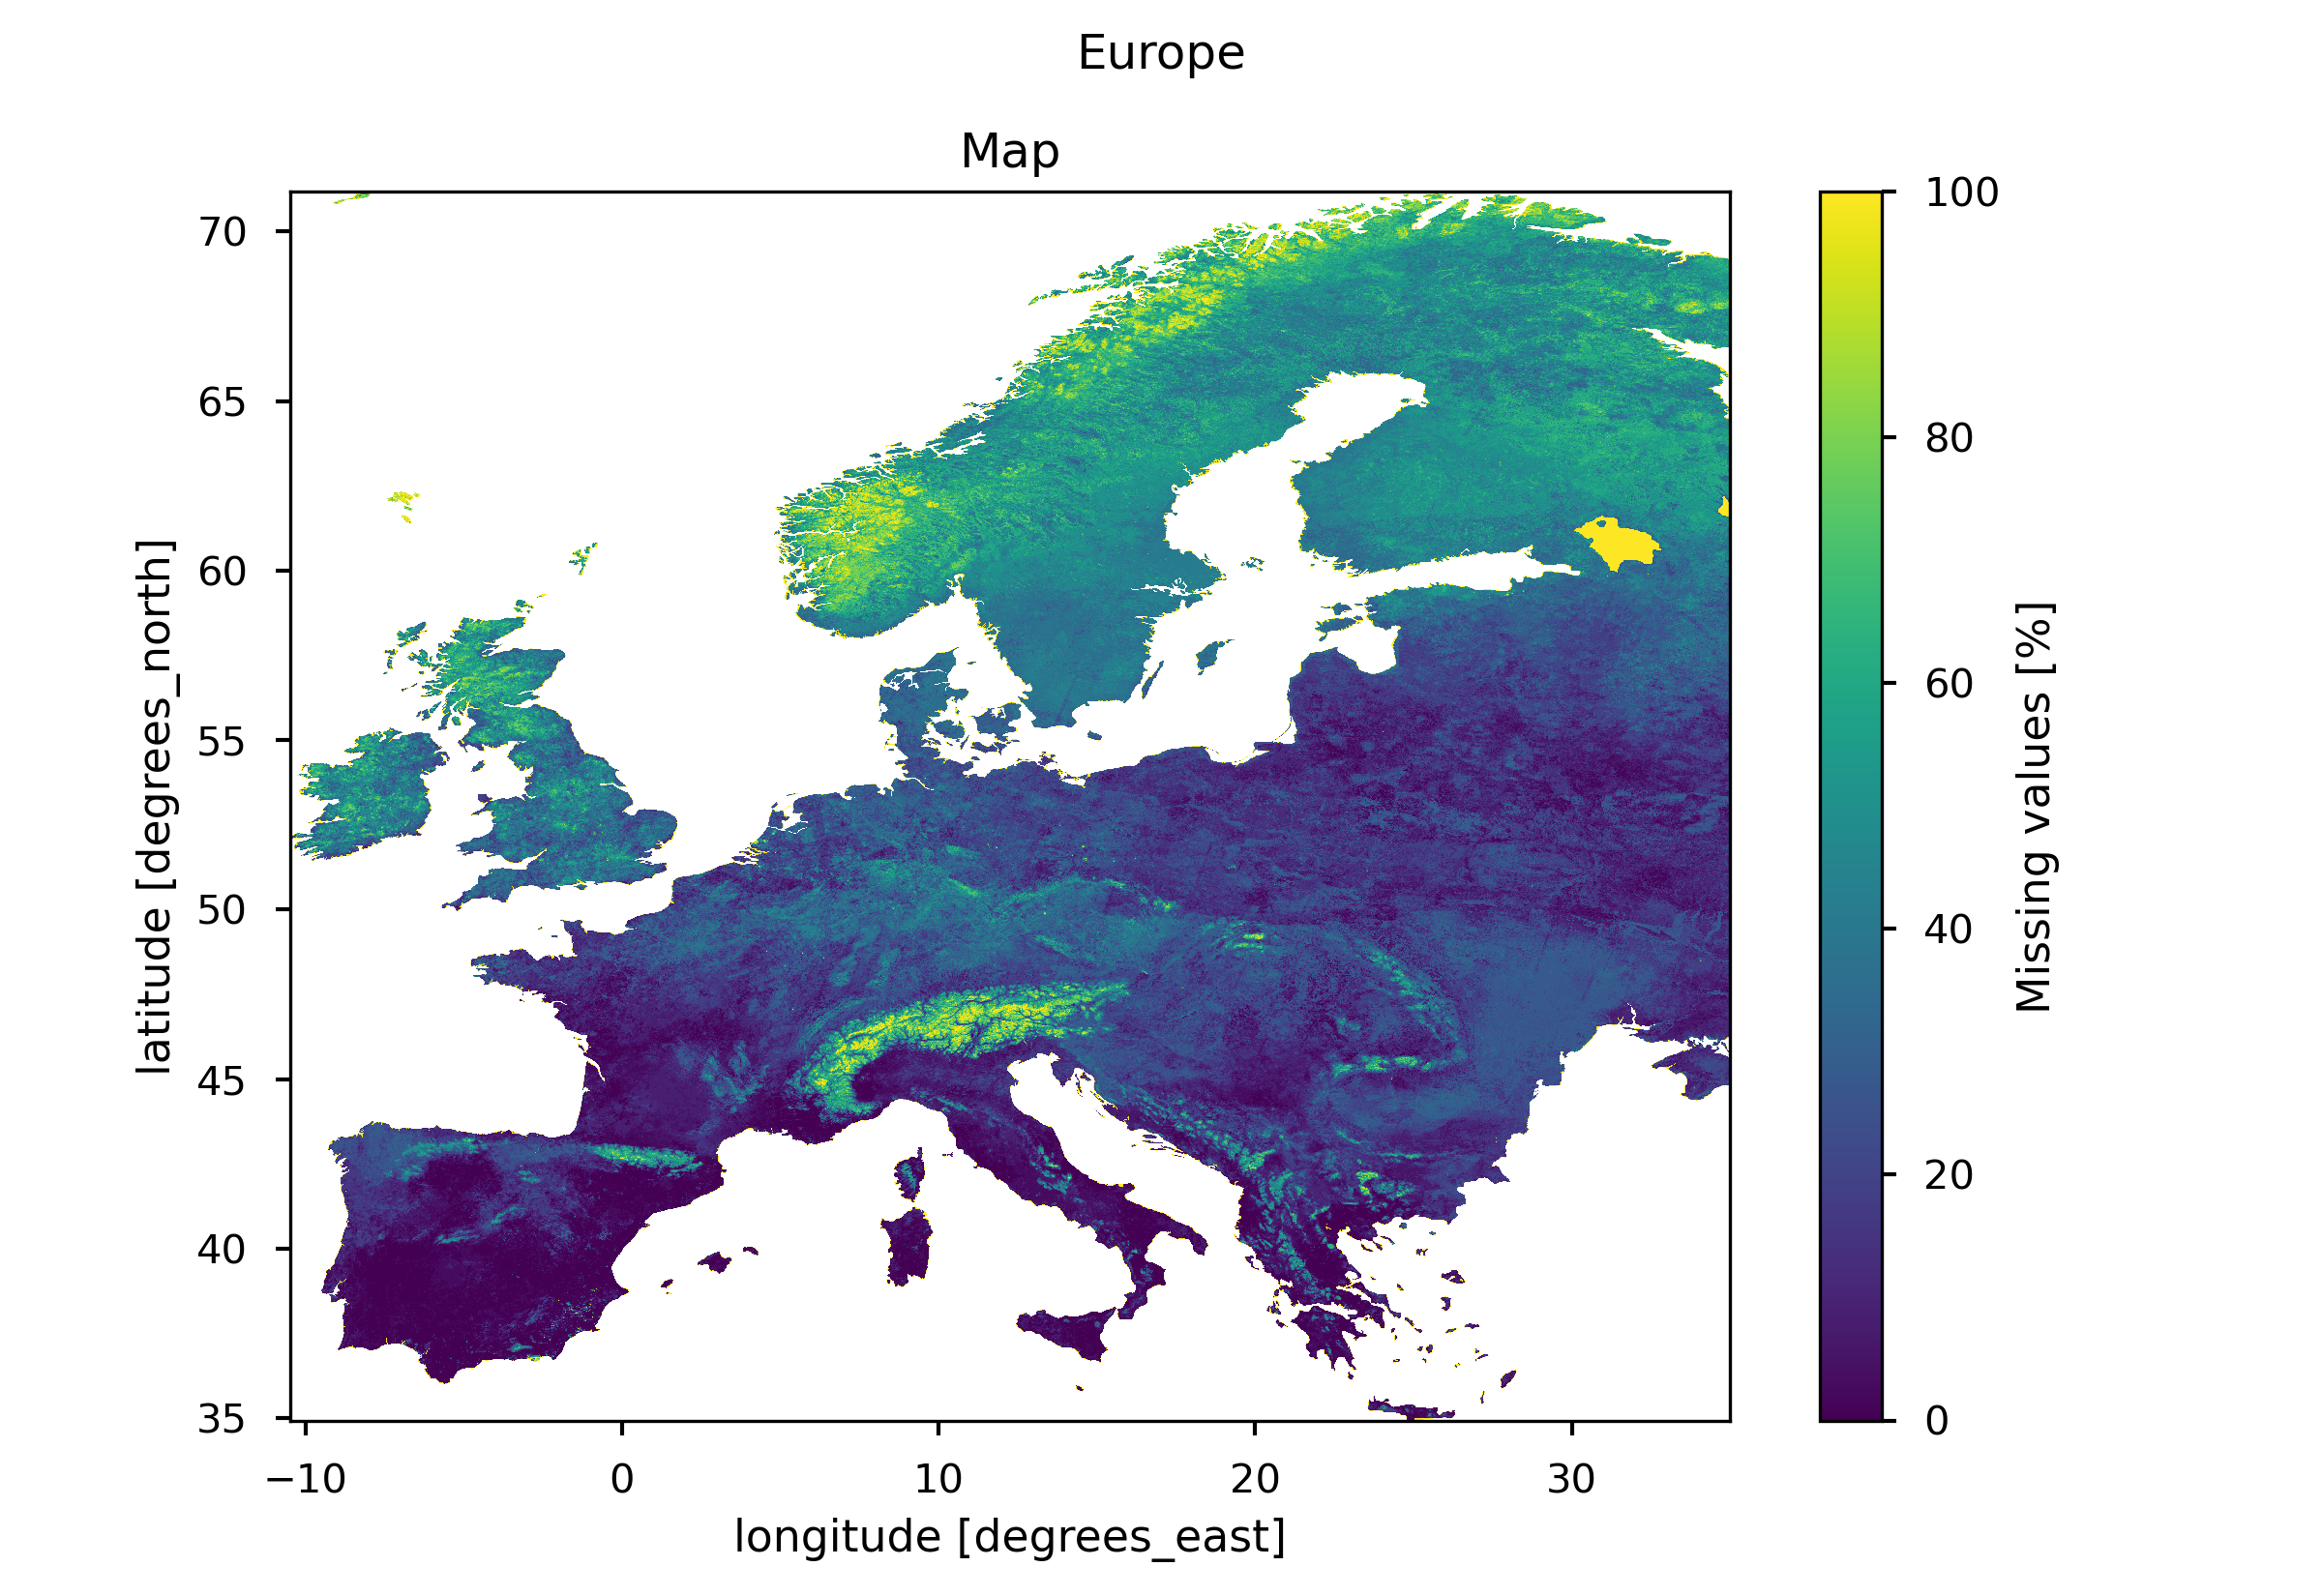

## 📋 Methodology

The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](section-1)**
 * Define variables and data request
 * Download 'fapar' variable by selecting the bounding box of Europe

**[](section-2)**
 * Calculate percentage of missing values for each pixel

**[](section-3)**
 * Plot a map showing the percentage of missing values for each pixel
 * Plot a histogram showing the percentage of missing values


## 📈 Analysis and results

(section-1)=
### 1. Data request and download

#### Import packages


Import c3s_eqc_automatic_quality_control library and packages to manage the data.

In [2]:
import fsspec
import geopandas
import matplotlib.pyplot as plt
import shapely.geometry
from c3s_eqc_automatic_quality_control import download, utils

plt.style.use("seaborn-v0_8-notebook")

#### Define variables


Set the starting and ending year of analysis and url of Europe shapefile.

In [3]:
# Request parameters
year_start = 2014
year_stop = 2014
nominal_days = [3, 13, 21, 23, 24]
variables = ["fapar"]

# Region
lon_slice = slice(-13, 35)
lat_slice = slice(72, 30)

shapefile_url = "https://figshare.com/ndownloader/files/23392280"

#### Set data request


Select the request, specifying the collection (satellite-lai-fapar), variable (fapar), satellite, sonsor and product version.

In [4]:
# Define request
collection_id = "satellite-lai-fapar"
request = {
    "satellite": "proba",
    "sensor": "vgt",
    "horizontal_resolution": "1km",
    "product_version": "V2",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "nominal_day": [f"{day:02d}" for day in nominal_days],
    "format": "zip",
    "variable": variables,
}


#### Download and preprocess data

Download data.

In [5]:
# Download and cache
ds = download.download_and_transform(
    collection_id,
    request,
    transform_func=utils.regionalise,
    transform_func_kwargs={
        "lon_slice": lon_slice,
        "lat_slice": lat_slice,
    },
    chunks={"year": 1, "nominal_day": 1, "variable": 1},
    cached_open_mfdataset_kwargs={"combine": "nested", "concat_dim": "time"},
)

# Shapefile
with fsspec.open(f"simplecache::{shapefile_url}") as file:
    world_shape = geopandas.read_file(file, layer="Continents")

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


(section-2)=
### 2. Define function to compute missing values count and plot

#### Define function to compute missing values count
Function that calculate for each grid cell the number of NA values for the entire time period selected.

In [5]:
def compute_missing_values_count(ds):
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)

    da_mvc = ds["fAPAR"].isnull().sum("time") / ds.sizes["time"] * 100
    da_mvc.attrs["long_name"] = "Missing values"
    da_mvc.attrs["units"] = "%"

    return da_mvc.to_dataset(name="fAPAR")

#### Define plotting function
Define a plotting function to create a side-by-side visualization of the clipped European map and a histogram of missing values.

In [7]:
def imshow_and_hist(da, shape):
    """Plot map and histogram side-by-side.

    Parameters
    ----------
    da: DataArray
        DataArray to plot
    shape: GeoDataFrame
        Geopandas object with polygons

    Returns
    -------
    figure, axes
    """
    fig, (ax_imshow, ax_hist) = plt.subplots(
        1, 2, figsize=[10, 5], gridspec_kw={"width_ratios": [3, 2]}
    )

    da = da.rio.clip(
        shape.geometry.apply(shapely.geometry.mapping),
        shape.crs,
        drop=True,
    )
    da.plot.imshow(ax=ax_imshow)
    ax_imshow.set_title("Map")

    da.plot.hist(bins=50, ax=ax_hist)
    ax_hist.set_ylabel("Frequency")
    ax_hist.yaxis.set_label_position("right")
    ax_hist.yaxis.tick_right()

    # Compute and show no data percentage
    missing_data_perc = (da == 100).sum() / da.notnull().sum() * 100
    ax_hist.set_title(
        f"Percentage of pixels with no data respect the total: {float(missing_data_perc):f} %"
    )

    fig.suptitle(", ".join(list(shape.CONTINENT)))
    return fig, (ax_imshow, ax_hist)

(section-3)=
### 3. Results

#### Plot Europe map
Visualize on overview of the percentage of missing values for each pixel.

(<Figure size 1000x500 with 3 Axes>,
 (<Axes: title={'center': 'Map'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <Axes: title={'center': 'Percentage of pixels with no data respect the total: 1.600201 %'}, xlabel='Missing values [%]', ylabel='Frequency'>))

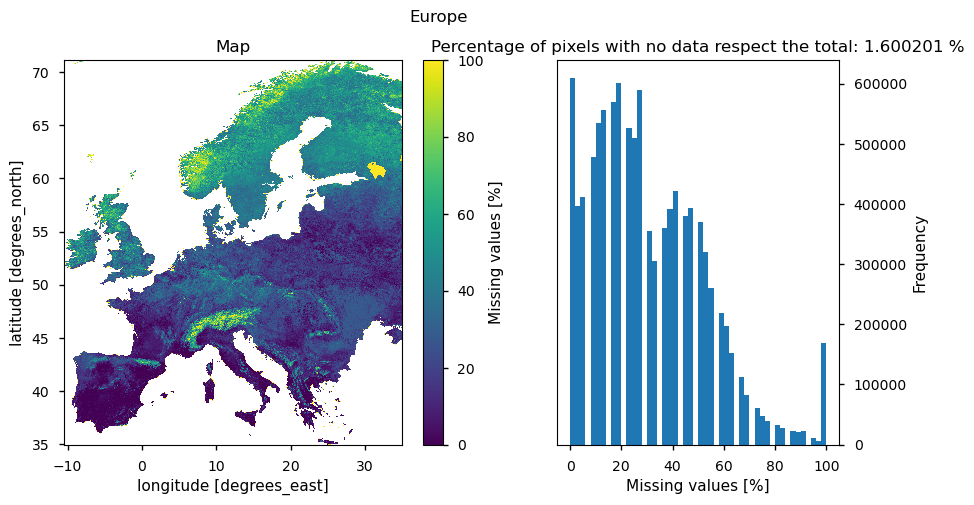

In [8]:
da_mvc = ds["fAPAR"].isnull().sum("time") / ds.sizes["time"] * 100
da_mvc.attrs["long_name"] = "Missing values"
da_mvc.attrs["units"] = "%"

da_mvc.rio.write_crs("epsg:4326", inplace=True)
imshow_and_hist(da_mvc, world_shape[world_shape.CONTINENT == "Europe"])

The analysis reveals a variation in the percentage of missing values across different geographical areas. Regions such as southern Spain and much of Italy exhibit minimal percentages, approaching zero. In contrast, northern Europe experiences higher percentages, reaching up to 60%. The code is set for a specific year (2014) and a specific region (Europe). It can be used to check data completeness for different years or different countries, or a shapefile of a specific basin can be uploaded for a more detailed analysis.


## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

Dataset documentation:

[PQAD](https://datastore.copernicus-climate.eu/documents/satellite-lai-fapar/D2.2.10-v4.1_PQAD_CDR-ICDR_LAI_FAPAR_SENTINEL3_v4.0_PRODUCTS_v1.1.pdf), Product quality assurance document

